In [1]:
###-----------------
### Import libraries
###-----------------
import sys
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
from utils.helper import fn_plot_confusion_matrix,fn_plot_torch_hist
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
import os 
os.path.curdir

'.'

In [3]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
inpDir = Path('..') / '..' / 'input'
# outDir = '../output'
outDir = Path('..') / 'output'


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
torch.manual_seed(RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
NOISE = 0.2
EPOCHS = 1000
ALPHA = 0.001
N_SAMPLE  = 1000


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

<h1>FOR GPU</h1>

In [4]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
data_df = pd.read_csv('Wine.csv')
data_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [7]:
for col in data_df.columns:
    print(data_df[col].unique())

[14.23 13.2  13.16 14.37 13.24 14.2  14.39 14.06 14.83 13.86 14.1  14.12
 13.75 14.75 14.38 13.63 14.3  13.83 14.19 13.64 12.93 13.71 12.85 13.5
 13.05 13.39 13.3  13.87 14.02 13.73 13.58 13.68 13.76 13.51 13.48 13.28
 13.07 14.22 13.56 13.41 13.88 14.21 13.9  13.94 13.82 13.77 13.74 13.29
 13.72 12.37 12.33 12.64 13.67 12.17 13.11 13.34 12.21 12.29 13.49 12.99
 11.96 11.66 13.03 11.84 12.7  12.   12.72 12.08 12.67 12.16 11.65 11.64
 12.69 11.62 12.47 11.81 12.6  12.34 11.82 12.51 12.42 12.25 12.22 11.61
 11.46 12.52 11.76 11.41 11.03 12.77 11.45 11.56 11.87 12.07 12.43 11.79
 12.04 12.86 12.88 12.81 12.53 12.84 13.36 13.52 13.62 12.87 13.32 13.08
 12.79 13.23 12.58 13.17 13.84 12.45 14.34 12.36 13.69 12.96 13.78 13.45
 12.82 13.4  12.2  14.16 13.27 14.13]
[1.71 1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 1.48 1.73 1.81
 1.92 1.57 1.59 3.1  1.63 3.8  1.86 1.6  2.05 1.77 1.72 1.9  1.68 1.5
 1.66 1.83 1.53 1.8  1.65 3.99 3.84 1.89 3.98 4.04 3.59 2.02 1.75 1.67
 1.7  1.97 1.43 0.94 

<Axes: >

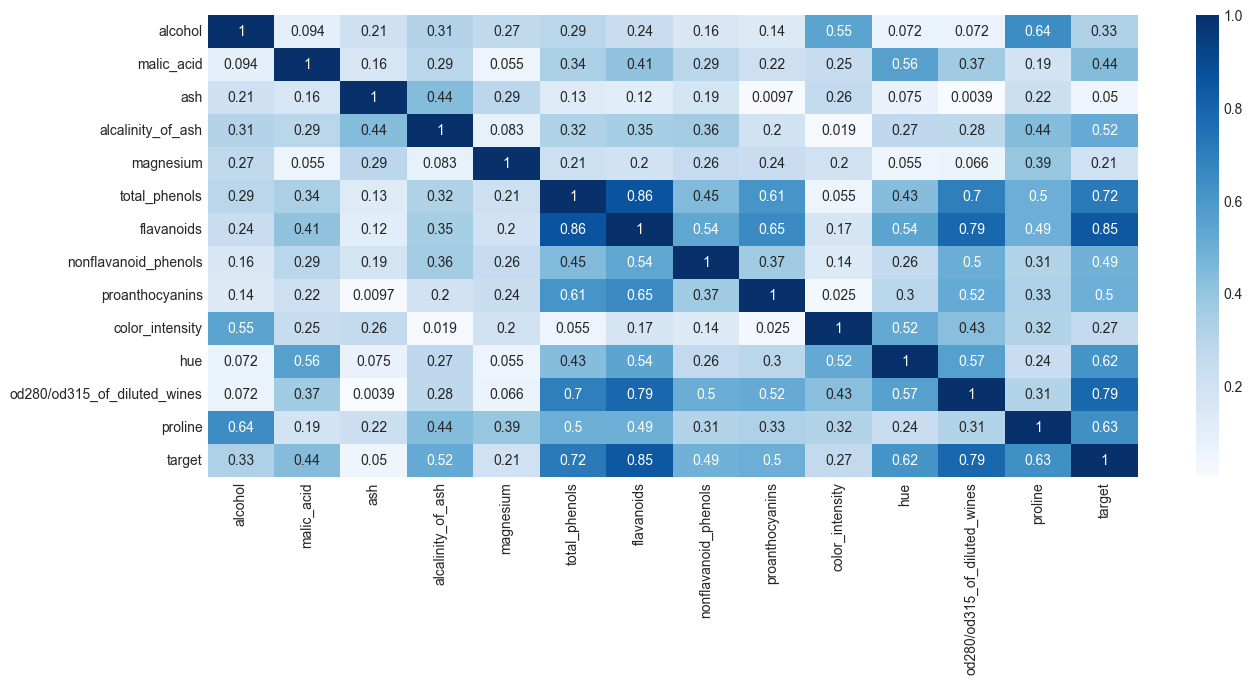

In [8]:
fig, ax = plt.subplots()
sns.heatmap(data_df.corr().abs(),
            ax = ax,
            cmap = 'Blues', 
            annot=True, 
            fmt = '.2g')

In [9]:
labels = data_df[data_df.columns[-1]]
feature_df = data_df.drop(data_df.columns[-1],axis = 1)
feature_df.shape,labels.shape

((178, 13), (178,))

In [10]:
X_train,X_test,y_train,y_test = train_test_split(feature_df,labels,
                                                stratify=labels,
                                                test_size=TEST_SIZE,
                                                 random_state = RANDOM_STATE)

In [11]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<h1>Define Model</h1>

In [13]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1],8),
    nn.ReLU(),
    nn.Linear(8,3)
)

display(model)

Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=3, bias=True)
)

In [14]:
summary(model.to(device = device),(1,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]             112
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 3]              27
Total params: 139
Trainable params: 139
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
#loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = ALPHA)

In [16]:
#training set and testing set tensors

train_X = torch.tensor(X_train,dtype = torch.float32,device = device)
test_X = torch.tensor(X_test,dtype = torch.float32,device = device)

train_y = torch.tensor(y_train,dtype = torch.int64,device = device) #for backpropogation we must parse it to int64
test_y = torch.tensor(y_test,dtype = torch.int64,device = device)

<h1>UNIT TEST</h1>

In [17]:
pred = model(train_X[:1])
pred

tensor([[-0.5731, -0.5509,  0.1616]], grad_fn=<AddmmBackward0>)

In [18]:
loss_fn(pred,train_y[:1])

tensor(1.4128, grad_fn=<NllLossBackward0>)

In [19]:
train_loss,test_loss = [] ,[] 
train_acc,test_acc = [] ,[] 

for epoch in range(EPOCHS):
    model.train()
    outputs = model(train_X)
    loss = loss_fn(outputs,train_y)
    optimizer.zero_grad()  
    loss.backward() 
    optimizer.step()
    train_loss.append(loss.item())
    _, y_pred = torch.max(outputs,1)

    curr_acc = accuracy_score(y_train,y_pred.data.cpu())
    train_acc.append(curr_acc)

    with torch.no_grad():
        model.eval()
        output = model(test_X)
        tloss = loss_fn(output,test_y).numpy()
        test_loss.append(tloss.item())
        _, y_pred_test = torch.max(output,1)

        t_curr_acc = accuracy_score(y_test,y_pred_test.data.cpu())
        test_acc.append(t_curr_acc)
    if epoch % 10 == 0:
        print(f'EPOCH : {epoch} - Loss : {loss.item():.4f} - {tloss.item():.4f}')
        # print(optimizer.state)

EPOCH : 0 - Loss : 1.1825 - 1.1679
EPOCH : 10 - Loss : 1.1424 - 1.1264
EPOCH : 20 - Loss : 1.1062 - 1.0899
EPOCH : 30 - Loss : 1.0722 - 1.0543
EPOCH : 40 - Loss : 1.0386 - 1.0184
EPOCH : 50 - Loss : 1.0045 - 0.9814
EPOCH : 60 - Loss : 0.9694 - 0.9435
EPOCH : 70 - Loss : 0.9337 - 0.9052
EPOCH : 80 - Loss : 0.8979 - 0.8662
EPOCH : 90 - Loss : 0.8621 - 0.8274
EPOCH : 100 - Loss : 0.8256 - 0.7887
EPOCH : 110 - Loss : 0.7875 - 0.7492
EPOCH : 120 - Loss : 0.7478 - 0.7092
EPOCH : 130 - Loss : 0.7061 - 0.6689
EPOCH : 140 - Loss : 0.6622 - 0.6266
EPOCH : 150 - Loss : 0.6164 - 0.5831
EPOCH : 160 - Loss : 0.5696 - 0.5397
EPOCH : 170 - Loss : 0.5234 - 0.4978
EPOCH : 180 - Loss : 0.4789 - 0.4580
EPOCH : 190 - Loss : 0.4372 - 0.4206
EPOCH : 200 - Loss : 0.3987 - 0.3861
EPOCH : 210 - Loss : 0.3631 - 0.3548
EPOCH : 220 - Loss : 0.3309 - 0.3269
EPOCH : 230 - Loss : 0.3019 - 0.3021
EPOCH : 240 - Loss : 0.2757 - 0.2793
EPOCH : 250 - Loss : 0.2523 - 0.2587
EPOCH : 260 - Loss : 0.2316 - 0.2387
EPOCH : 270 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   epoch          1000 non-null   int64  
 1   loss           1000 non-null   float64
 2   test_loss      1000 non-null   float32
 3   Accuracy       1000 non-null   float64
 4   Test_Accuracy  1000 non-null   float64
dtypes: float32(1), float64(3), int64(1)
memory usage: 35.3 KB


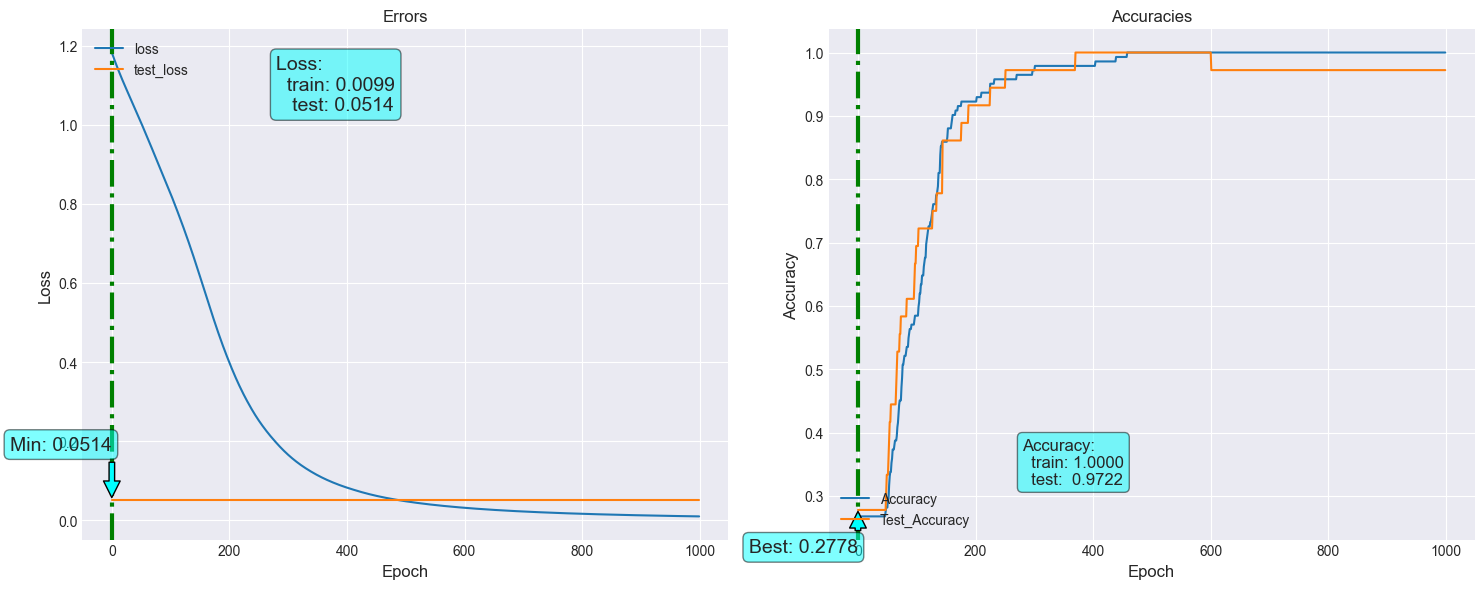

In [20]:
loss_df2 = pd.DataFrame({
    'epoch': range(EPOCHS),
    'loss' : train_loss,
    'test_loss' : tloss,
    'Accuracy' : train_acc,
    'Test_Accuracy' : test_acc
    
})
loss_df2.info()
fn_plot_torch_hist(loss_df2)

<h1>Evaluation</h1>

In [21]:
model.eval()
with torch.no_grad():
    train_pred = model(train_X)
    test_pred = model(test_X)
type(train_pred),type(test_pred)

(torch.Tensor, torch.Tensor)

In [22]:
y_train_pred = train_pred.detach().cpu().numpy()
y_train_pred = y_train_pred.argmax(axis = 1)
y_train_pred

array([0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2,
       0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 0, 0, 1,
       2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 0, 2, 2])

In [23]:
class_name = {}
for i ,cl in enumerate(le.classes_):
    class_name[i] = cl
class_name

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

In [24]:
print(f'Accuracy : {accuracy_score(y_train,y_train_pred)}')
print(f'Accuracy : {classification_report(y_train,y_train_pred)}')


Accuracy : 1.0
Accuracy :               precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



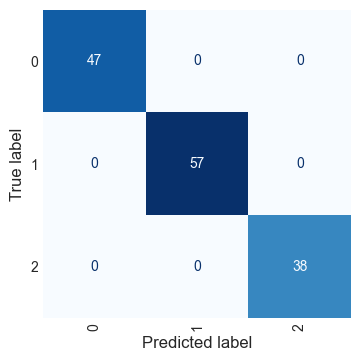

In [25]:
fn_plot_confusion_matrix(y_train,y_train_pred,class_name)